In [1]:
import tensorflow as tf
import mtcnn
from mtcnn import MTCNN
import PIL
from PIL import Image
import numpy as np
import pandas as pd
from IPython.display import display
import os
import matplotlib.pyplot as pyplot
from tensorflow.keras.models import load_model
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib 
import cv2

Using TensorFlow backend.


In [2]:
FaceNet = load_model('../keras-facenet/model/facenet_keras.h5')

In [3]:
SVM_model = joblib.load('../Face Recognition/SVM_model.pkl')

In [4]:
name = joblib.load('../Face Recognition/label.pkl')

In [5]:
normalizer = Normalizer(norm = 'l2')
detector = MTCNN()

In [6]:
name

{0: 'Aditya Solanki',
 1: 'Ben Afflek',
 2: 'Elton John',
 3: 'Jerry Seinfeld',
 4: 'Madonna',
 5: 'Mindy Kaling',
 6: 'Unknown'}

In [8]:
def predict_face(FaceNet, SVM_model, filename, normalizer, detector):
    image = Image.open(filename)
    #Convert the file to RGB
    image = image.convert('RGB')
    #Convert the File to Numpy array to be machine readable
    pixels = np.asarray(image)
    
    #Extracting Face embeddings from the Photo
    result = detector.detect_faces(pixels)
    #print(result)
    if len(result) == 0 :
        print ('No Face detected in this photo')
        return []
    else:
        predictions_dict = {}
        for i in range(len(result)):
            return_name = ''
            x1, y1, width, height = 0 , 0 , 0, 0
            co_ordinates = []
            x1, y1, width, height = result[i]['box']
            co_ordinates.append(x1)
            co_ordinates.append(y1)
            co_ordinates.append(width)
            co_ordinates.append(height)
            x1, y1 = abs(x1) , abs(y1)
            x2, y2 = abs(x1) + width , abs(y1) + height 
            face = pixels[y1:y2, x1:x2]
            image = Image.fromarray(face)
            image = image.resize((160,160))
            face_array = np.asarray(image)
            face_pixels = face_array.astype('float32')
            mean, std = face_pixels.mean(), face_pixels.std()
            face_pixels  = (face_pixels - mean)/std
            samples = np.expand_dims(face_pixels, axis = 0)
            output = FaceNet.predict(samples)
            embeddings = np.asarray(output)
            embeddings_normalized = normalizer.transform(embeddings)
            prediction = SVM_model.predict(embeddings_normalized)
            prob = SVM_model.predict_proba(embeddings_normalized)
            return_name = name[prediction[0]] + '_' + str(i)
            co_ordinates.append((prob.max() * 100))
            predictions_dict[return_name] = co_ordinates
    return predictions_dict

In [9]:
filename = ('../data/test/singers.jpg')
prediction = predict_face(FaceNet,SVM_model, filename, normalizer, detector)
prediction

{'Elton John_0': [238, 26, 63, 83, 87.75186048796664],
 'Madonna_1': [344, 54, 45, 58, 66.34681644637259],
 'Unknown_2': [151, 13, 43, 54, 42.62808941121074]}

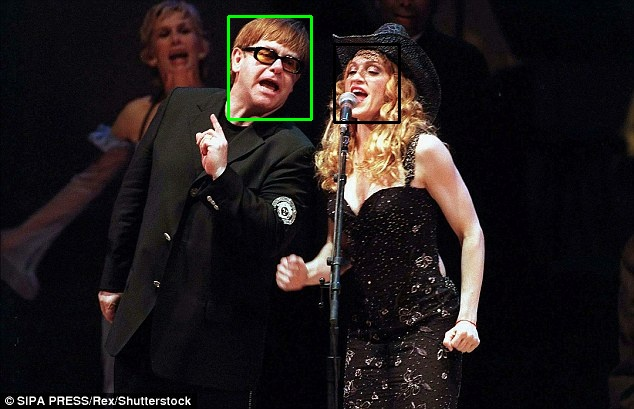

In [10]:
if len(prediction)== 0:
    print ('Sorry no output')
else:
    image = cv2.imread(filename)
    for i in prediction.keys():
        names = i.split('_')
        x1, y1, width, height ,percent  = 0,0,0,0, 0
        x1, y1, width, height , percent = prediction[i]
        if names[0] == 'Unknown' or percent < 65 :
            continue
        else:
            x1, y1 = abs(x1) , abs(y1)
            x2, y2 = abs(x1) + width , abs(y1) + height
            x1 -= 10
            y1 -= 10
            x2 += 10
            y2 += 10
            start_point = (x1, y2) 
            end_point = (x2, y1)
            # Color Order by Blue Green Red
            if names[0] == 'Aditya Solanki':
                color = (0,255, 255)#Yellow
            elif names[0] == 'Ben Afflek':
                color = (255,0, 0) #Blue
            elif names[0] == 'Elton John':
                color = (0,255, 0) #Green
            elif names[0] == 'Jerry Seinfeld':
                color = (0,0, 255) #Red
            elif names[0] == 'Madonna':
                color = (0, 0, 0) #Black
            elif names[0] == 'Mindy Kaling':
                color = (255, 255, 255) #White
            elif names[0] == 'Unknown':
                color = (255,255, 0) #Aqua
            thickness = 2
            image = cv2.rectangle(image, start_point, end_point, color, thickness) 
    cv2.imwrite('Highlighted.jpg', image)
image = Image.open('Highlighted.jpg')
image